In [1]:
%pylab inline
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import shapiro
from statsmodels.tsa.stattools import acf, pacf
from scipy.signal import periodogram
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller


Populating the interactive namespace from numpy and matplotlib


/Users/johnip/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv('1343393.csv')

In [8]:
date = pd.to_datetime(df['DATE'])

In [9]:
temp = pd.Series(df['TMAX'], index = date)

In [10]:
#pd.Series()

In [11]:
#{df['DATE']:df['TMAX']}

In [12]:
d = {pd.to_datetime(df['DATE'][i]):df['TMAX'][i] for i in range(len(df['DATE']))}
pretty_time_series = pd.Series(d)

In [13]:
pretty_time_series = pretty_time_series.asfreq('D',method='pad')

In [14]:
pretty_time_series = pretty_time_series.fillna(method='pad')

In [15]:

ys = np.linspace(1931,2017,87)
ms = np.linspace(1,12,12)


Constuct monthly averages

In [16]:
monthly_temp = []
for yy in ys:
    for mm in ms:
        keychain = [i for i in pretty_time_series.keys() if (i.month == mm)&(i.year == yy)]
        monthly_temp.append(np.median(pretty_time_series[keychain]))
    

In [17]:
rng = pd.date_range('1931-1-01', periods=87*12, freq='M')


In [18]:
pretty_time_series_monthly = pd.Series(monthly_temp,index = rng)

This is the temperature time series from 1931 to 2018

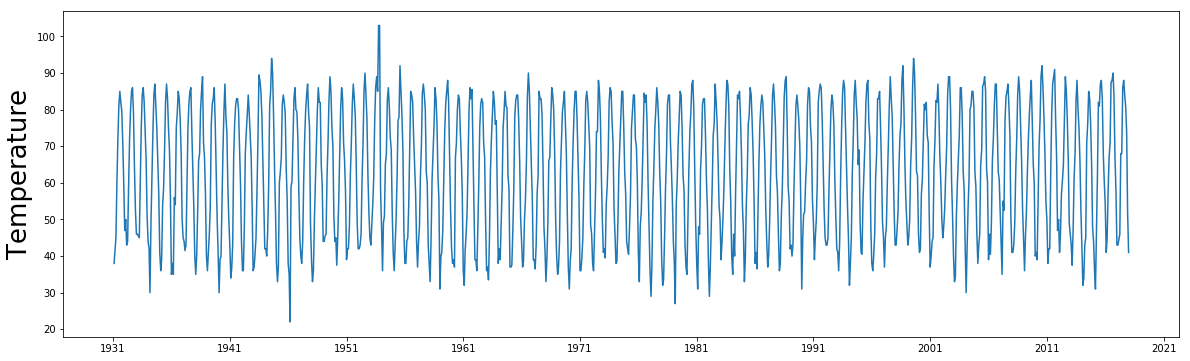

In [19]:
plt.figure(figsize = (20,6))
plt.plot(pretty_time_series_monthly)
plt.ylabel('Temperature',fontsize=26)
plt.savefig('basic.png',bbox_inches='tight')

In [20]:
monthly_temp = np.array([pretty_time_series_monthly.values[i::12][:87] for i in range(12)])

In [21]:
average_monthly_temp = [np.mean(i) for i in monthly_temp]

This is the average seasonal variation

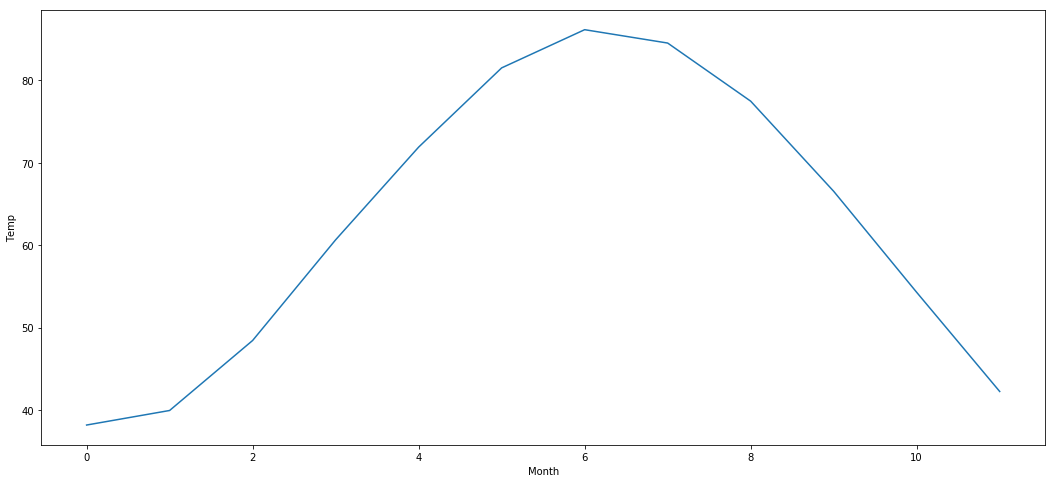

In [41]:
plt.figure(figsize = (18,8))
plt.plot(average_monthly_temp)
seasonal_model = np.array(average_monthly_temp*87)
delta = pretty_time_series_monthly-seasonal_model
plt.xlabel("Month")
plt.ylabel('Temp')

This plot has three panels. Top: Full time series. Middle: Average Seasonal Variation. Bottom: Residual

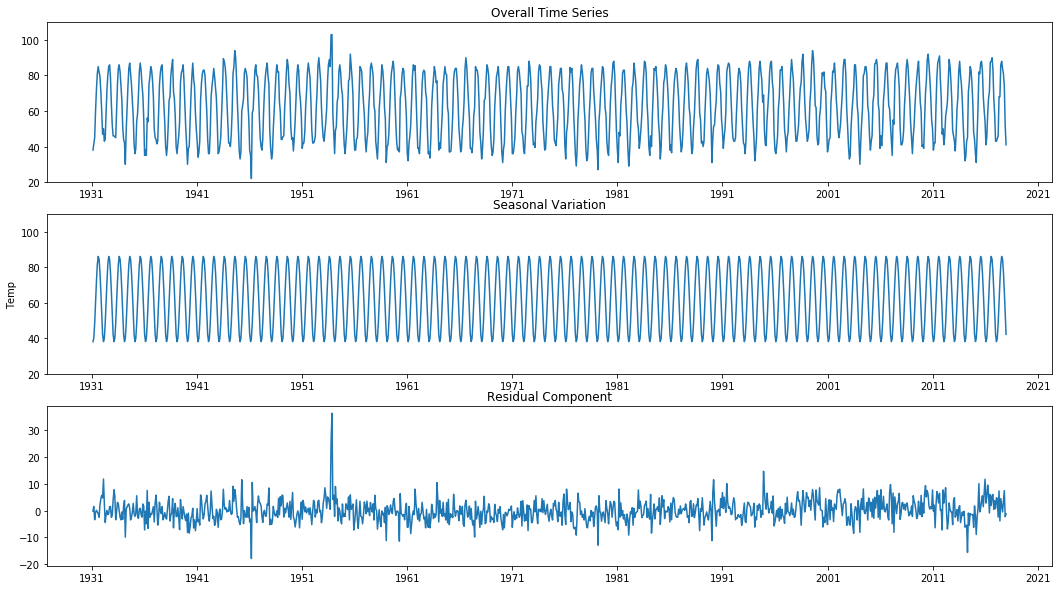

In [23]:
plt.figure(figsize=(18,10))
plt.subplot(311)
plt.plot(pretty_time_series_monthly)
plt.ylim(20,110)
plt.title('Overall Time Series')
#plt.plot(np.array(average_monthly_temp*87))
plt.subplot(312)
plt.ylim(20,110)

plt.title('Seasonal Variation')
plt.ylabel('Temp')
plt.plot(pretty_time_series_monthly.index,seasonal_model)
plt.subplot(313)
plt.title('Residual Component')
plt.plot(delta)
plt.savefig('Temp_decomp.png',bbox_inches='tight')

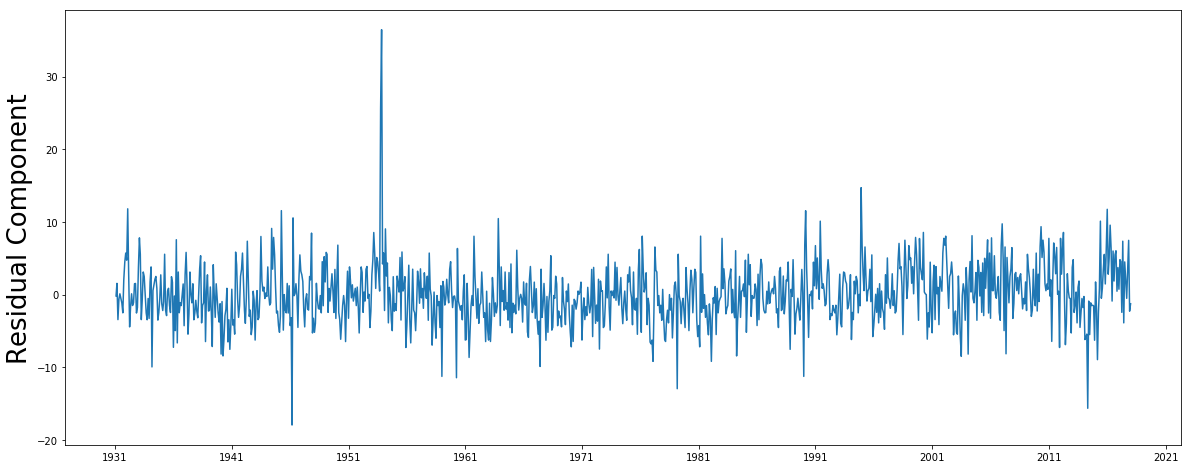

In [24]:
plt.figure(figsize = (20,8))
plt.plot(delta)
plt.ylabel('Residual Component',fontsize = 26)

plt.savefig('Delta.png',bbox_inches='tight')

Let's do a quick Augmented Dickey-Fuller test for stationarity

In [25]:
delta = pd.Series(delta,index=rng)
adfuller(delta)

(-8.1599606781083907,
 9.2003954192179385e-13,
 6,
 1037,
 {'1%': -3.4366716595409041,
  '10%': -2.5682561222519897,
  '5%': -2.8643311477003515},
 5692.0224845819166)

Autocorrelation and partial Autocorrelation

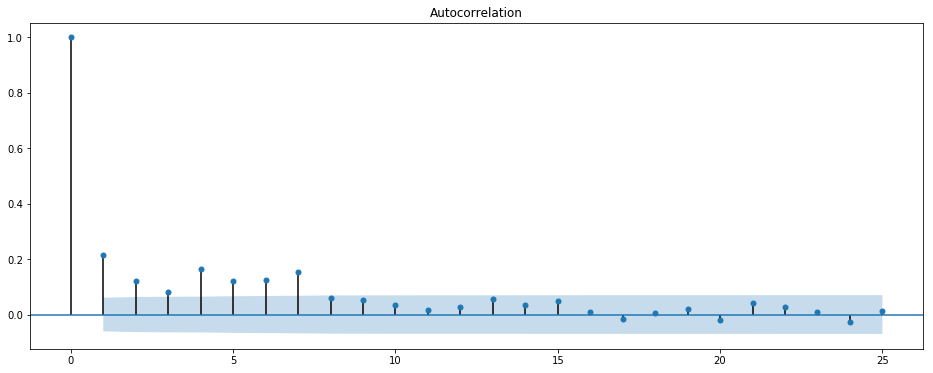

In [26]:
fig = plt.figure(figsize = (16,6))
ax1=plt.gca()
plot_acf(delta,ax = ax1,lags=25)
plt.savefig('autocorr.png',bbox_inches='tight')

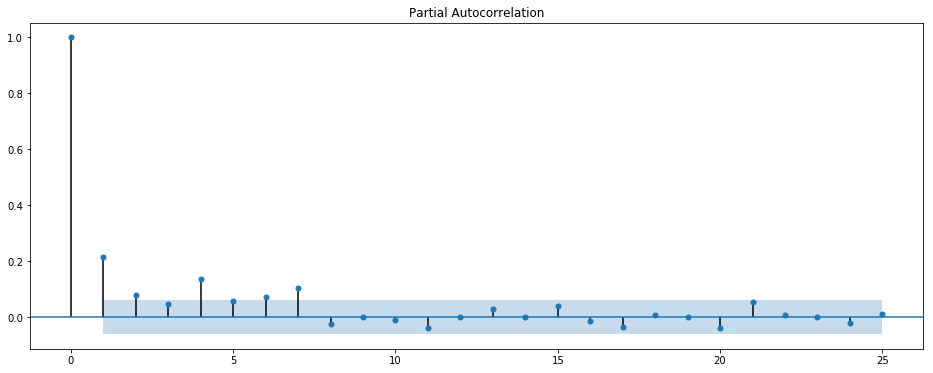

In [27]:
fig = plt.figure(figsize = (16,6))
ax1=plt.gca()
plot_pacf(delta,ax = ax1,lags=25)
plt.savefig('partial_autocorr.png',bbox_inches='tight')

Let's cut the sample down a little, focusing on 1993 to 2008. Our training sample will be from 1993 to 2003 and our test sample will be from 2003 to 2008.

In [28]:
cycles = 25
end_cycles = 15
end_cycles_2 = 10
windowed = delta[(87-cycles)*12:(87-end_cycles)*12]
windowed2 = delta[(87-end_cycles)*12:(87-end_cycles_2)*12]

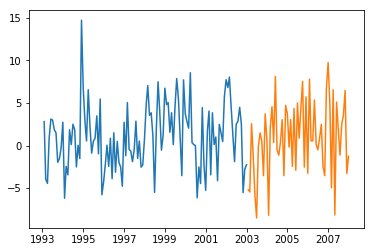

In [29]:
plt.plot(windowed[::])
plt.plot(windowed2)

Construct ARMA model

In [30]:
ar,i,ma = 4,0,4

In [31]:
model = ARIMA(windowed,(ar,i,ma))

In [32]:
fit_model = model.fit()

/Users/johnip/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Here's the ARMA fit.

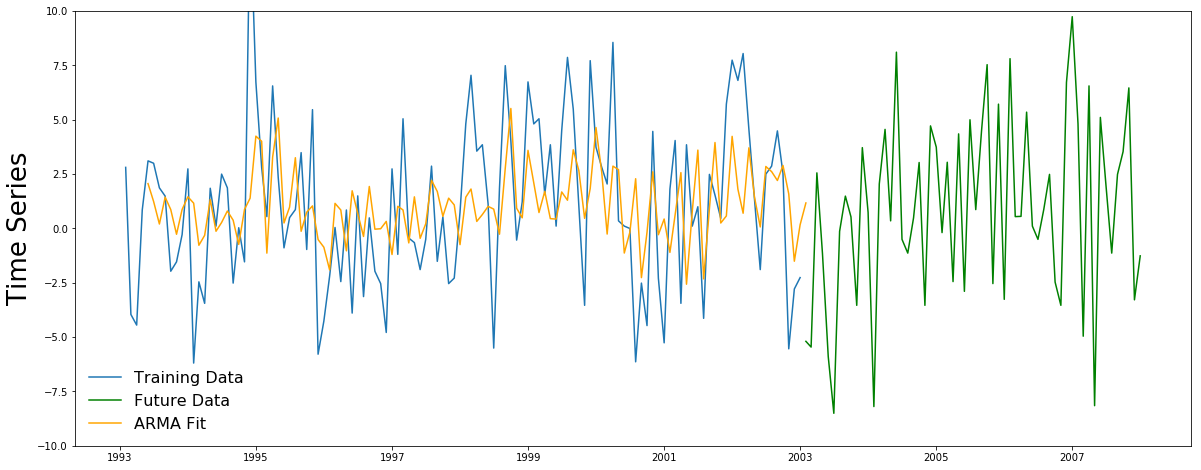

In [33]:
plt.figure(figsize(20,8))
plt.plot(windowed[:],label = 'Training Data')
plt.plot(windowed2[:],c='g', label = 'Future Data')
#scale = np.sqrt(median(windowed**2)/median(fit_model.fittedvalues**2))
plt.plot(fit_model.predict(4,120,dynamic=False),c = 'orange',label = 'ARMA Fit')
leg = plt.legend(loc=3,fontsize = 16)
leg.draw_frame(False)
plt.ylim(-10,10)
plt.ylabel('Time Series',fontsize = 26)
plt.savefig('ARMA_fit.png',bbox_inches='tight')

Plotting ARMA predictions.

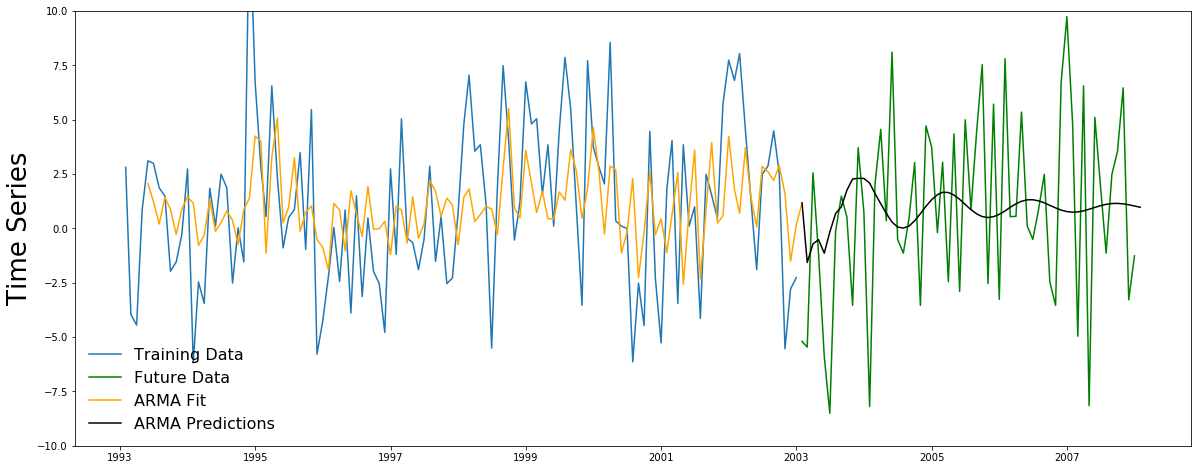

In [34]:
plt.figure(figsize(20,8))
plt.plot(windowed[:],label = 'Training Data')
plt.plot(windowed2[:],c='g', label = 'Future Data')
#scale = np.sqrt(median(windowed**2)/median(fit_model.fittedvalues**2))
plt.plot(fit_model.predict(4,120,dynamic=False),c = 'orange',label = 'ARMA Fit')
plt.plot(fit_model.predict(120,180,dynamic=False),c = 'k',label = 'ARMA Predictions')

leg = plt.legend(loc=3,fontsize = 16)
leg.draw_frame(False)
plt.ylim(-10,10)
plt.ylabel('Time Series',fontsize = 26)
plt.savefig('ARMA_predict.png',bbox_inches='tight')

In [35]:
naiive = [mean(windowed[:])]*len(fit_model.predict(120,180,dynamic=False).index)

Plotting naive predictions.

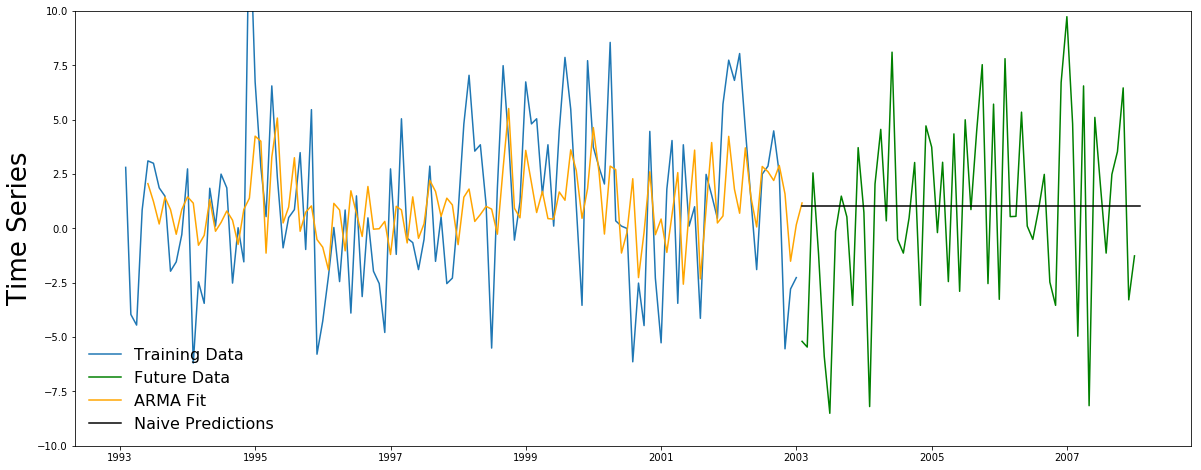

In [36]:
plt.figure(figsize(20,8))
plt.plot(windowed[:],label = 'Training Data')
plt.plot(windowed2[:],c='g', label = 'Future Data')
#scale = np.sqrt(median(windowed**2)/median(fit_model.fittedvalues**2))
plt.plot(fit_model.predict(4,120,dynamic=False),c = 'orange',label = 'ARMA Fit')
plt.plot(fit_model.predict(120,180,dynamic=False).index,naiive,c = 'k',label = 'Naive Predictions')

leg = plt.legend(loc=3,fontsize = 16)
leg.draw_frame(False)
plt.ylim(-10,10)
plt.ylabel('Time Series',fontsize = 26)
plt.savefig('naive_predict.png',bbox_inches='tight')

In [37]:
naiive_resid = naiive[1:] - windowed2
arma_resid = fit_model.predict(120,180,dynamic=False) - windowed2

#arma_resid

Naive residual analysis

0.179166666667
4.25248958865


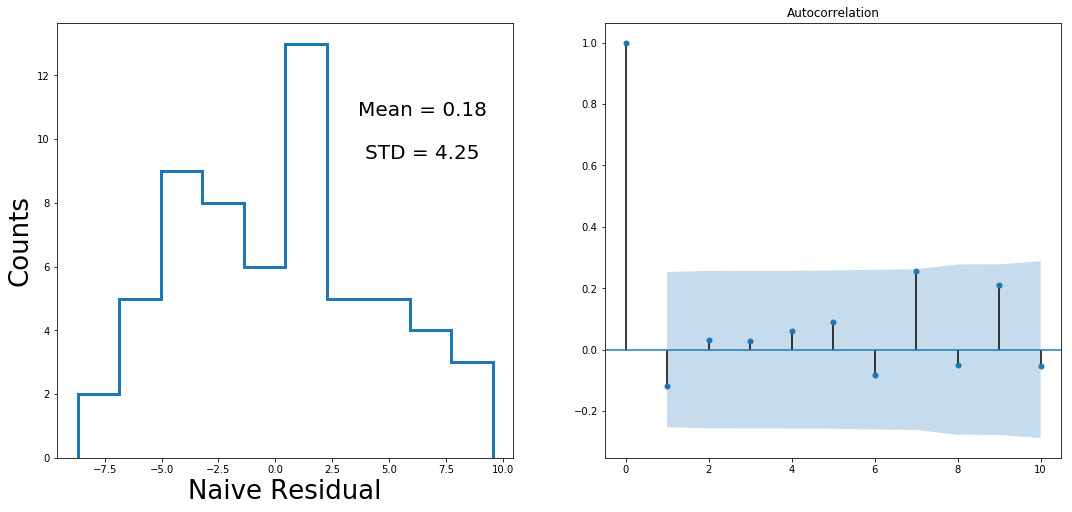

In [38]:
plt.figure(figsize = (18,8))
ax1 = plt.subplot(121)
plt.hist(naiive_resid,histtype = 'step',lw = 3)
plt.xlabel('Naive Residual',fontsize=26)
plt.ylabel('Counts',fontsize=26)
plt.text(0.8, 0.8,'Mean = {:.2f}'.format(mean(naiive_resid)), horizontalalignment='center',verticalalignment='center',transform=ax1.transAxes,fontsize = 20)
plt.text(0.8, 0.7,'STD = {:.2f}'.format(std(naiive_resid)), horizontalalignment='center',verticalalignment='center',transform=ax1.transAxes,fontsize = 20)

print(mean(naiive_resid))
print(std(naiive_resid))
ax2 = plt.subplot(122)
plot_acf(naiive_resid,ax = ax2,lags=10)
plt.savefig('Naive_resid.png',bbox_inches='tight')

ARMA residual analysis

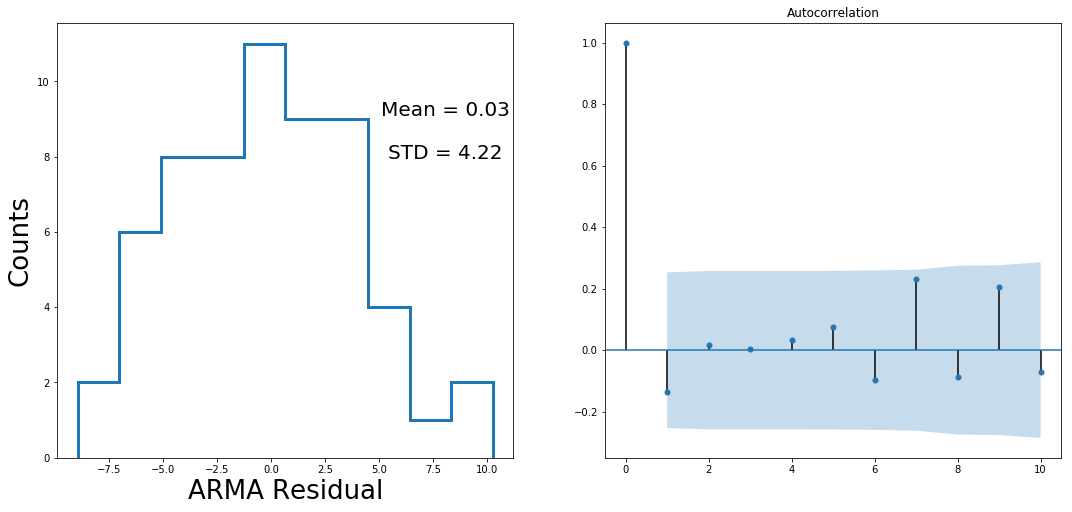

In [39]:
plt.figure(figsize = (18,8))
ax1 = plt.subplot(121)
plt.hist(arma_resid[:-1],histtype = 'step',lw = 3)
plt.xlabel('ARMA Residual',fontsize=26)
plt.ylabel('Counts',fontsize=26)
plt.text(0.85, 0.8,'Mean = {:.2f}'.format(mean(arma_resid[:-1])), horizontalalignment='center',verticalalignment='center',transform=ax1.transAxes,fontsize = 20)
plt.text(0.85, 0.7,'STD = {:.2f}'.format(std(arma_resid[:-1])), horizontalalignment='center',verticalalignment='center',transform=ax1.transAxes,fontsize = 20)

ax2 = plt.subplot(122)
plot_acf(arma_resid[:-1],ax = ax2,lags=10)
plt.savefig('ARMA_resid.png',bbox_inches='tight')

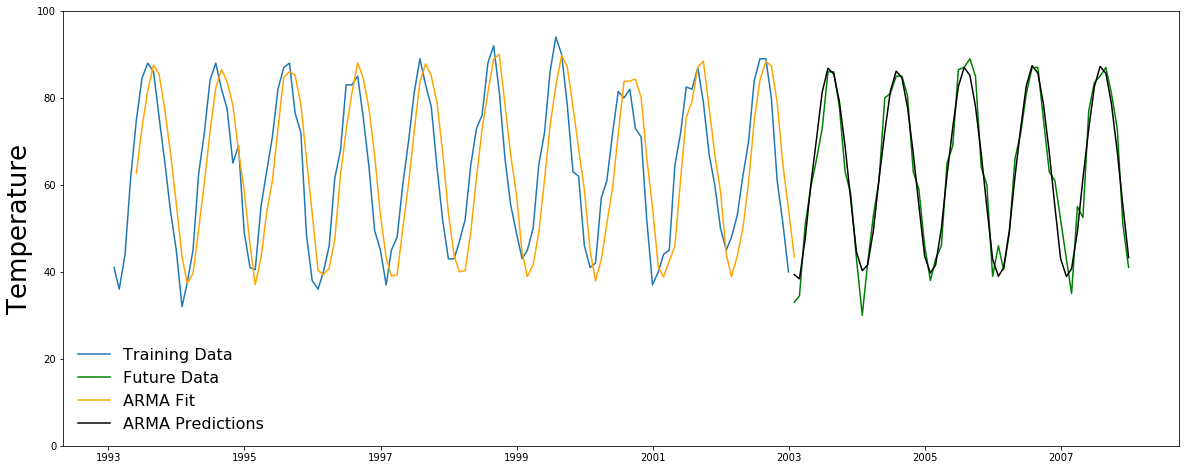

In [40]:
plt.figure(figsize(20,8))
plt.plot(windowed[:]+np.array(list(average_monthly_temp)*(len(windowed)/len(average_monthly_temp))),label = 'Training Data')
plt.plot(windowed2[:]+np.array(list(average_monthly_temp)*(len(windowed2)/len(average_monthly_temp))),c='g', label = 'Future Data')
#scale = np.sqrt(median(windowed**2)/median(fit_model.fittedvalues**2))
plt.plot(fit_model.predict(4,120,dynamic=False)+np.array(list(average_monthly_temp)*10)[3:],c = 'orange',label = 'ARMA Fit')
plt.plot(fit_model.predict(120,180,dynamic=False)[:-1]+np.array(list(average_monthly_temp)*5)[:],c = 'k',label = 'ARMA Predictions')
leg = plt.legend(loc=3,fontsize = 16)
leg.draw_frame(False)
plt.ylim(0,100)
plt.ylabel('Temperature',fontsize = 26)
plt.savefig('ARMA_predict_final.png',bbox_inches='tight')